In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
import scipy.signal
import tsfresh
import pickle
from tqdm import tqdm
import inspect
import sys
from scipy.signal import savgol_filter
sys.path.append("src/data_processing/")
sys.path.append("src/validation/")
import dp_utils as dp

In [ ]:
%%time

filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train.csv'

df = pd.read_csv(filepath, 
                 dtype={"acoustic_data": np.int16, "time_to_failure": np.float32}, 
                 skiprows=1, 
                 names=['s', 'ttf'])

In [ ]:
filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train/train.h5'

df.to_hdf(filepath, key='table')

In [2]:
# filepath = '/home/sergey/Projects/Kaggle/LANL-Earthquake-Prediction/train/train.h5'
# filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train.h5'
filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train_short.h5'

df = pd.read_hdf(filepath, key='table')

In [ ]:
# filepath = './data/train_short_processed.h5'
filepath = '/Users/sergey/Dev/Kaggle/LANL-Earthquake-Prediction/train/train_processed.h5'

df_processed = pd.read_hdf(filepath, key='table')

In [ ]:
df_processed


In [ ]:
from inspect import getmembers, isfunction

funcname_list = [o[0] for o in getmembers(dp) if isfunction(o[1])]
funcref_list = [o[1] for o in getmembers(dp) if isfunction(o[1])]

In [ ]:
import json

dp_config = {"data_path": "../../data/train_short.h5", 
             "data_processed_path": "../../data/train_short_processed.h5", 
             "window_length": 10000,
             "routines": {}}

In [ ]:
for obj in funcref_list[:-1]:
    inspect_obj = inspect.signature(obj)
    params_dict = dict(inspect_obj.parameters)
    params = {}
    for k, v in params_dict.items():
        if v.default != inspect._empty:
            params[k] = v.default      
    dp_config["routines"][obj.__name__] = {"on": True, "params": params}
    
dp_config

In [ ]:
func_list = []
for name in list(dp_config['routines'].keys()):
    func_list.append(getattr(dp, name))

# 3. Run processing
routine_settings = list(dp_config['routines'].values())

dfp = pd.concat(
    [func(df['s'], **setting['params']) for func, setting in zip(func_list, routine_settings) if setting['on']],
    axis=1)

In [ ]:
with open("/Users/sergey/Documents/Projects/Kaggle/LANL-Earthquake/src/validation/Model 1", 'rb') as file:  
    pickle_model = pickle.load(file)

In [41]:
test = [1, 3, 4]
test2 = [np.array([1, 2, 3])]

print(pd.DataFrame([t for t in test2]))

   0  1  2
0  1  2  3


w_psd(df, window_size=5000), fs=4000000.0): 100%|██████████| 200/200 [00:00<00:00, 2593.83it/s]
	 window decorator: 
	 - window size: 5000


,"w_psd(df, window_size=5000), fs=4000000.0)"
0,0.292630
1,0.021338
2,0.035023
3,0.026474
4,0.017370
5,0.014168
6,0.037855
7,0.027071
8,0.037250
9,0.016869


w_psd(df, window_size=5000), fs=4000000.0): 100%|██████████| 200/200 [00:00<00:00, 2683.53it/s]
	 window decorator: 
	 - window size: 5000
w_psd(df, window_size=5000), fs=4000000.0): 100%|██████████| 200/200 [00:00<00:00, 2600.05it/s]
	 window decorator: 
	 - window size: 5000


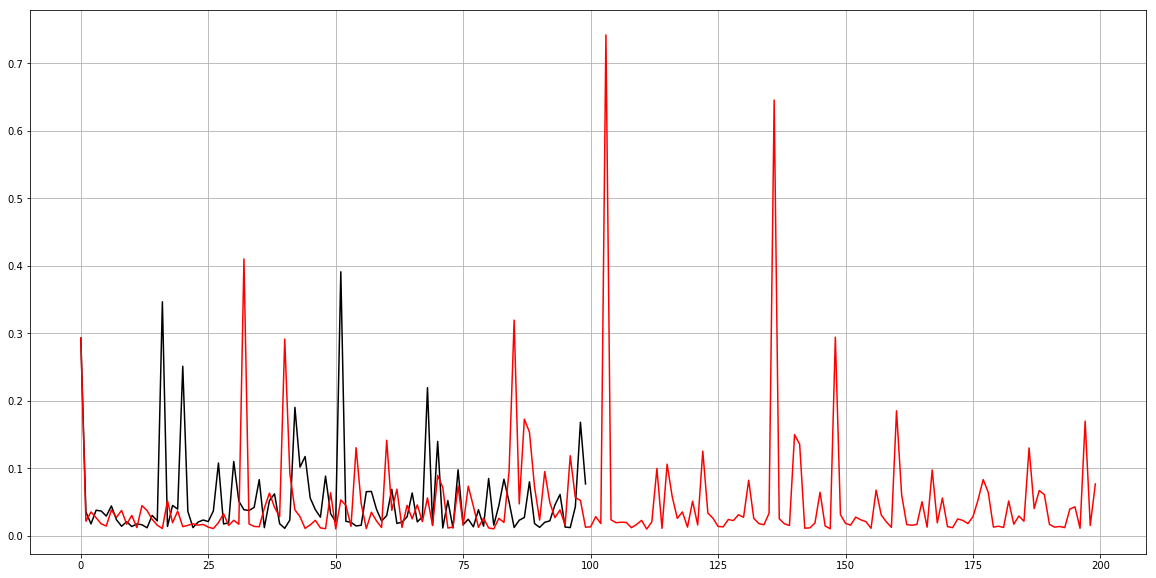

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(dp._upscale_column(dp.w_psd(df['s'], window_size=5000, fs=4e6), 100), 'k')
plt.plot(dp.w_psd(df['s'], window_size=5000, fs=4e6), 'r')
plt.grid(True)
plt.show()

In [ ]:
def filter_decorator(window=21, poly_order=1):
    def filter_calc(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            df = func(args[0], *args, **kwargs)
            temp = savgol_filter(df.squeeze(), window, poly_order)
            return pd.DataFrame(temp, columns={func.__name__})
        return wrapper
    return filter_calc
        
def function_decorator(f, params):
    def filter_calc(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            df = func(args[0], *args, **kwargs)
            temp = f(df.squeeze(), **params)
            tqdm.write("\t function decorator: ")
            tqdm.write("\t - {}{}".format(f.__name__, inspect.signature(f)))
            tqdm.write("\t - params: {}".format(params))
            return pd.DataFrame(temp, columns={func.__name__ + '+' + f.__name__ + '({})'.format(params)})
        return wrapper
    return filter_calc

def window_decorator(window_size=10000):
    def window_calc(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            temp = []
            df = args[0]
            inspect_params = inspect.getfullargspec(func)
            for i in tqdm(range(0, df.shape[0], window_size), 
                    desc=func.__name__ + "({}, ".format(*inspect_params.args)
                          + ', '.join("{}={})".format(k, v) for k, v in kwargs.items()), file=sys.stdout):
                batch = df.iloc[i: i+window_size].values
                temp.append(func(batch, *args, **kwargs))
            tqdm.write("\t window decorator: ")
            tqdm.write("\t - window size: {}".format(window_size))
            return pd.DataFrame(temp, columns={func.__name__})
        return wrapper
    return window_calc

In [ ]:
@function_decorator(savgol_filter, {"window_length": 21, "polyorder": 1})
@window_decorator()
def w_mean(df, *args, **kwargs):
    return np.mean(df)

@function_decorator(savgol_filter, {"window_length": 21, "polyorder": 1})
@window_decorator()
def w_min(df, *args, **kwargs):
    return np.min(df)

@filter_decorator()
@window_decorator()
def w_psd(df, *args, fs=4e6, **kwargs):
    return np.sum(scipy.signal.periodogram(df, fs=fs)[1])

@window_decorator()
def w_psd_raw(df, *args, fs=4e6, **kwargs):
    return np.sum(scipy.signal.periodogram(df, fs=fs)[1])

In [ ]:
w_mean(df['s'])
w_min(df['s'])

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(w_psd_raw(df['s']), 'k')
plt.plot(w_psd(df['s']), 'r')

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(w_mean(df['s']).values, 'k')
plt.plot(savgol_filter(w_mean(df['s']).values.squeeze(), window_length=21, polyorder=2), 'r')
plt.grid(True)
plt.show()

In [ ]:
predictions = pickle_model.predict(df_processed.drop(['w_labels'], axis=1))
actual_values = df_processed['w_labels']
print(len(abs(predictions - actual_values)))

plt.figure(figsize=(20, 10))
# plt.plot(predictions, 'r')
plt.plot(scipy.signal.periodogram(actual_values.values, fs=4e2)[1], 'k')
plt.ylim([0, 100])
plt.xlim([0, 1000])
plt.grid(True)
plt.show()

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(15 * rng.rand(800, 1), axis=0)
y = np.sin(X).ravel()
# y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=3)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 15.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
df['s'].values

In [ ]:
t = {}
if not t:
    print("H")

In [ ]:
@window_decorator()
def w_last(df, *args, **kwargs):
    return df[-1]

In [ ]:
df_processed = df_processed.join(dp.w_labels(df['ttf']))

In [ ]:
df_processed

In [ ]:
w_last(df['ttf'])

In [ ]:
def window_decorator(window_size=10000):
    def window_calc(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            temp = []
            df = args[0]
            inspect_params = inspect.getfullargspec(func)
            for i in tqdm(range(0, df.shape[0], window_size), 
                    desc=func.__name__ + "({}, ".format(*inspect_params.args)
                          + ', '.join("{}={})".format(k, v) for k, v in kwargs.items())):
                batch = df.iloc[i: i+window_size].values
                temp.append(func(batch, *args, **kwargs))
            return pd.DataFrame(temp, columns={func.__name__})
        return wrapper
    return window_calc

In [ ]:
@window_decorator()
def w_autocorrelation(df, *args, lag=100, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.autocorrelation(df, lag=lag)
@window_decorator()
def w_psd(df, *args, fs=4e6, **kwargs):
    return np.sum(scipy.signal.periodogram(df, fs=fs)[1])
@window_decorator()
def w_min(df, *args, **kwargs):
    return np.min(df)
@window_decorator()
def w_absolute_sum_of_changes(df, *args, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(df)
@window_decorator()
def w_sample_entropy(df, *args, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.sample_entropy(df)
@window_decorator()
def w_symmetry_looking(df, *args, r=0.1, **kwargs):
    return tsfresh.feature_extraction.feature_calculators.symmetry_looking(df, param={"r": r})